# 📊 A/B Testing Analysis: Cookie Cats Mobile Game

## 1. Контекст проекта

**Cookie Cats** — это популярная мобильная игра-головоломка (в стиле "три в ряд"). По мере прохождения уровней игроки сталкиваются с **"воротами" (gates)**, которые вынуждают их сделать паузу. Чтобы продолжить игру, нужно либо подождать определенное время, либо совершить внутри игровую покупку.

Эти "ворота" служат двум целям:

 - Дают игрокам передышку, чтобы игра не надоела (продлевают удовольствие).

 - Монетизируют игру (покупки).

## 2. Бизнес-задача и эксперимент

Разработчики хотят оптимизировать удержание игроков **(Retention)**. Было проведено A/B тестирование, в котором изменили местоположение первых ворот:

 - **Control Group (Gate_30):** Ворота находятся на уровне 30.

 - **Test Group (Gate_40):** Ворота перенесены на уровень 40.

**Цель:** Понять, влияет ли перенос ворот на удержание игроков (Retention Rate) на 1-й и 7-й день после установки игры.

## 3. Описание данных

Датасет содержит данные о 90,189 игроках. Переменные:

 - userid: Уникальный идентификатор игрока.

 - version: Группа эксперимента (gate_30 или gate_40).

 - sum_gamerounds: Количество сыгранных раундов в течение первых 14 дней.

 - retention_1: Вернулся ли игрок в игру через 1 день после установки? (True/False).

 - retention_7: Вернулся ли игрок в игру через 7 дней после установки? (True/False).

## 4. Гипотезы

Мы проверим статистическую значимость различий между группами.
 - **Нулевая гипотеза ($H_0$):** Разницы в удержании (Retention) между группами Gate_30 и Gate_40 нет.
 - **Альтернативная гипотеза ($H_1$):** Разница в удержании есть (перенос ворот влияет на поведение игроков).

# Data Cleaning

## 1. Импорт библиотек и настройки

In [1]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats 

In [2]:
# Настройка внешнего вида графиков
sns.set(style='whitegrid', palette='muted')
%matplotlib inline

In [3]:
# Загрузка данных
df = pd.read_csv('cookie_cats.csv')

# Смотрим первые 5 строк, чтобы понять структуру
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 2. Первичная разведка

In [4]:
# Смотрим общую информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
# Проверка на наличие пустых значений (Null values)
print(df.isnull().sum())

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


Датасет чистый, пропусков нет.

## 3. Поиск "Ловушки"

In [6]:
# Описательная статистика по количеству сыгранных раундов
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

В значении **max** мы видим число **49854**, что является явным выбросом. Скорее всего, это тестовый бот разработчиков или баг.
Этот выброс искажает среднее значение.

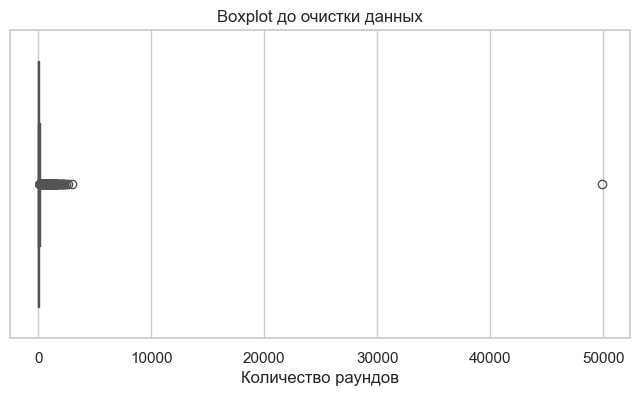

In [7]:
# Визуализация выброса, для наглядности
plt.figure(figsize=(8, 4))

sns.boxplot(x=df['sum_gamerounds'])

plt.title('Boxplot до очистки данных')
plt.xlabel('Количество раундов')

plt.show()

На графике можно увидеть одну точку далеко справа, что является выбросом.

## 4. Очистка данных

In [8]:
# Удаляем экстремальный выброс
df = df[df['sum_gamerounds'] < 40000]

print(f'Максимальное число раундов после очистки: {df["sum_gamerounds"].max()}')

Максимальное число раундов после очистки: 2961


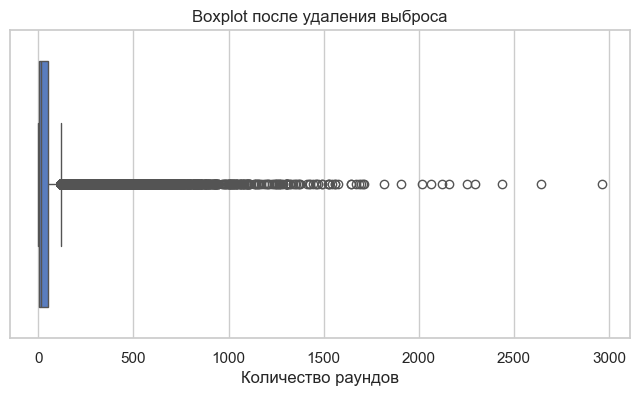

In [9]:
# Строим график, чтобы увидеть нормальное распределение
plt.figure(figsize=(8, 4))

sns.boxplot(x=df['sum_gamerounds'])
plt.title('Boxplot после удаления выброса')
plt.xlabel('Количество раундов')

plt.show()

Теперь график стал читаемым.
Хотя хвост справа все еще длинный, но это нормально для игр, поскольку существует группа игроков, именующая себя как хардкорщики.

## 5. Проверка сплитования

In [10]:
# Считаем количество пользователей в каждой группе
print(f"Контрольная группа: {df[df['version'] == 'gate_30']['userid'].count()} пользователей ({round((df[df['version'] == 'gate_30']['userid'].count() / df['userid'].count() * 100), 2)}%)")
print(f"Тестовая группа: {df[df['version'] == 'gate_40']['userid'].count()} пользователей ({round((df[df['version'] == 'gate_40']['userid'].count() / df['userid'].count() * 100), 2)}%)")

Контрольная группа: 44699 пользователей (49.56%)
Тестовая группа: 45489 пользователей (50.44%)


# EDA - Exploratory Data Analysis

## 1. Распределение сыгранных раундов

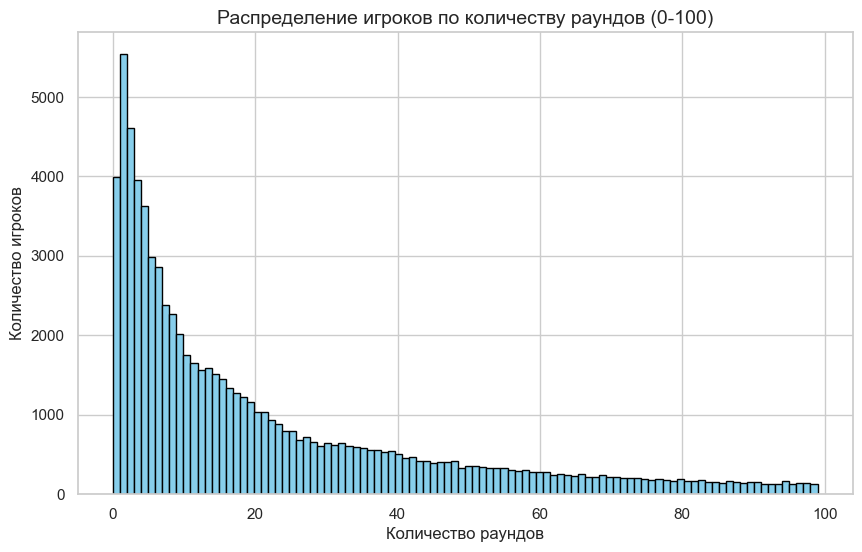

In [11]:
# Посмотрим на распределение игроков по количеству раундов
fig, ax = plt.subplots(figsize=(10, 6))
df[df['sum_gamerounds'] < 100]['sum_gamerounds'].hist(bins=100, color='skyblue', edgecolor='black')

plt.title('Распределение игроков по количеству раундов (0-100)', fontsize=14)
plt.xlabel('Количество раундов')
plt.ylabel('Количество игроков')

plt.show()

Обычный t-test здесь применять рисковванно, поскольку данные слишком скошены.

## 2. Сравниваем Retention

In [12]:
# Расчет Retention 1-го дня
retention_1 = df.groupby('version')['retention_1'].agg(['mean', 'count'])
print('Retention 1-го дня:')
print(f'{retention_1}\n')

# Расчет Retention 7-го дня
retention_7 = df.groupby('version')['retention_1'].agg(['mean', 'count'])
print('Retention 7-го дня:')
print(f'{retention_7}')

Retention 1-го дня:
             mean  count
version                 
gate_30  0.448198  44699
gate_40  0.442283  45489

Retention 7-го дня:
             mean  count
version                 
gate_30  0.448198  44699
gate_40  0.442283  45489


## 3. Визуализация разницы

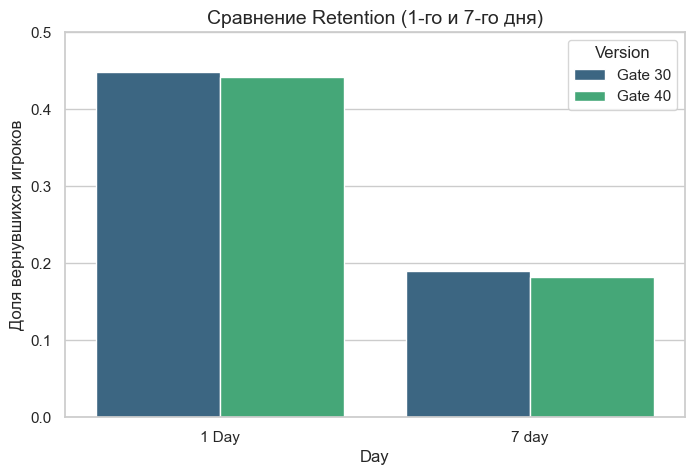

In [13]:
# Визуализируем данные про Retention
retention_data = pd.DataFrame({
    'Day': ['1 Day', '1 Day', '7 day', '7 day'],
    'Version': ['Gate 30', 'Gate 40', 'Gate 30', 'Gate 40'],
    'Retention': [
        df[df['version'] == 'gate_30']['retention_1'].mean(),
        df[df['version'] == 'gate_40']['retention_1'].mean(),
        df[df['version'] == 'gate_30']['retention_7'].mean(),
        df[df['version'] == 'gate_40']['retention_7'].mean()
    ]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=retention_data, x='Day', y='Retention', hue='Version', palette='viridis')

plt.title('Сравнение Retention (1-го и 7-го дня)', fontsize=14)
plt.ylim(0, 0.5)
plt.ylabel('Доля вернувшихся игроков')

plt.show()

Визуально группа Gate_30 показывает чуть более высокие показатели удержания как на 1-й, так и на 7-й день. Однако разница невелика (менее 1%), и нам необходимо проверить, является ли она статистически значимой, или это случайность.

# Bootstrapping

## 1. Bootstrap-скрипт

In [14]:
# Создаем списки для храниения разницы в Retention (Gate_30 - Gate_40)
boot_1d = []
boot_7d = []

# Количество итераций
iterations = 500

print('Bootstrap...')

for i in range(iterations):
    # Создаем подвыборку с возвращением
    boot_mean = df.sample(frac=1, replace=True).groupby('version')[['retention_1', 'retention_7']].mean()
    
    # Считаем разницу и сохраняем
    boot_1d.append(boot_mean.loc['gate_30']['retention_1'] - boot_mean.loc['gate_40']['retention_1'])
    boot_7d.append(boot_mean.loc['gate_30']['retention_7'] - boot_mean.loc['gate_40']['retention_7'])

print('Данные собраны.')

Bootstrap...
Данные собраны.


## 2. Kernel Density Estimate

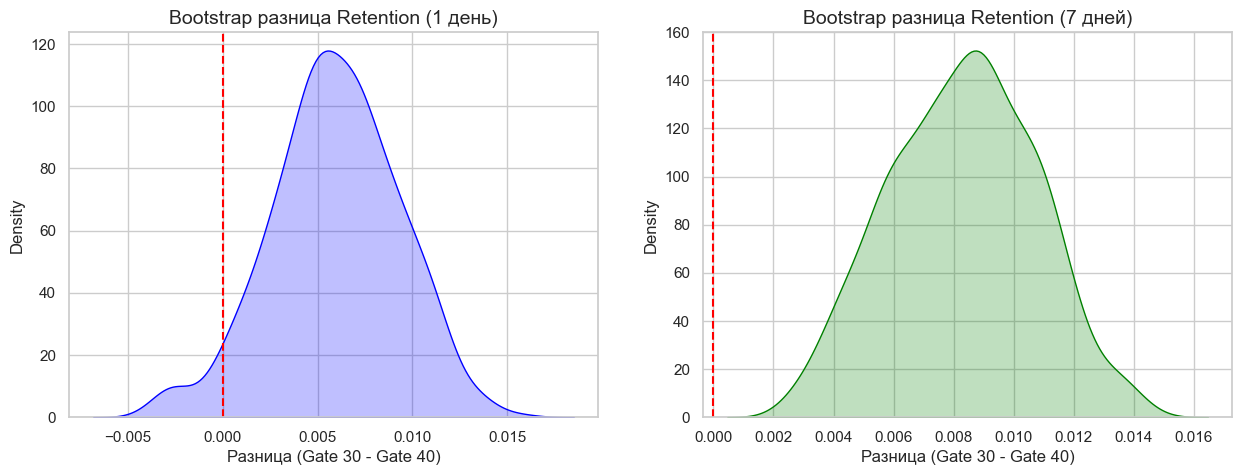

In [17]:
# Превращаем списки в DataFrame
boot_df = pd.DataFrame({
    'diff_1d': boot_1d,
    'diff_7d': boot_7d
})

# Строим графики распределения разницы
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# График для 1-го дня
sns.kdeplot(boot_df['diff_1d'], fill=True, ax=ax1, color='blue')

ax1.set_title('Bootstrap разница Retention (1 день)', fontsize=14)
ax1.set_xlabel('Разница (Gate 30 - Gate 40)')
ax1.axvline(0, color='red', linestyle='--')

# График для 7-го дня
sns.kdeplot(boot_df['diff_7d'], fill=True, ax=ax2, color='green')

ax2.set_title('Bootstrap разница Retention (7 дней)', fontsize=14)
ax2.set_xlabel('Разница (Gate 30 - Gate 40)')
ax2.axvline(0, color='red', linestyle='--')

plt.show()

## 3. Считаем вероятность

In [16]:
prob_1 = (boot_df['diff_1d'] > 0).mean()
prob_7 = (boot_df['diff_7d'] > 0).mean()

print(f'Вероятность того, что Retention 1-го дня выше при воротах на 30 уровне: {prob_1:.1%}')
print(f'Вероятность того, что Retention 7-го дня выше при воротах на 30 уровне: {prob_7:.1%}')

Вероятность того, что Retention 1-го дня выше при воротах на 30 уровне: 95.4%
Вероятность того, что Retention 7-го дня выше при воротах на 30 уровне: 100.0%


# Вывод и рекомендации для бизнеса

Мы провели глубокий анализ результатов A/B теста, используя метод **Bootstrap** для проверки статистической значимости различий в Retention Rate.

1. **Retention 1-го дня:** Разница между группами незначительна, но всё же склоняется в пользу gate_30.

2. **Retention 7-го дня:** Наблюдается сильная статистически значимая разница. Группа с воротами на 30-м уровне показывает более высокое удержание, чем группа с воротами на 40-м уровне.

3. Вероятность того, что Retention 7-го дня выше при воротах на 30-м уровне, составляет близко к **100%**.

Здесь работает психологический эффект "Гедонистической адаптации":

 - На 30-м уровне интерес игрока всё еще высок. Вынужденная пауза усиливает желание вернуться.

 - К 40-му уровню игроку может стать скучно. Если в этот момент дать ему паузу, он с большей вероятностью уйдет навсегда.

Итоговая рекомендация:
**Оставить ворота на уровне 30.** Это решение позволит сохранить более высокие показатели удержания (Retention 7-day) и, как следствие, LTV игроков.